# ASTR 310 HW 8

### 1. Making a contour plot with annotations

**a)** Create a contour plot of the function
$$ z(x,y) = \frac{1}{|y|+1} \sin (x^2 + y^2) \; e^{-x^2}$$
containing 15 contour levels equally spaced between the global minimum and maximum of the function within the domain 
$[-\pi, \pi] \times [-\pi, \pi]$.  [5 pts]

**b)** Find all the local minima and maxima of $z$. Indicate positions of the minima with circles and positions of the maxima with $\times$'s. Finding local extrema is nontrivial, so there are two ways you might do this task.  The easy but inelegant way is to loop over all the pixels of z and check whether they are larger or smaller than all of their neighbors.  The more elegant way is to use tests like `(z >= np.roll(z, -1, axis=0))` to eliminate the loop.  [10 pts]

**c)** Create a legend that shows that circles indicate minima and that $\times$'s indicate maxima. Be sure to include an appropriate title and labels for the $x$ and $y$ axes.  [5 pts]


In [503]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import astropy.table as table
from matplotlib.patches import Ellipse

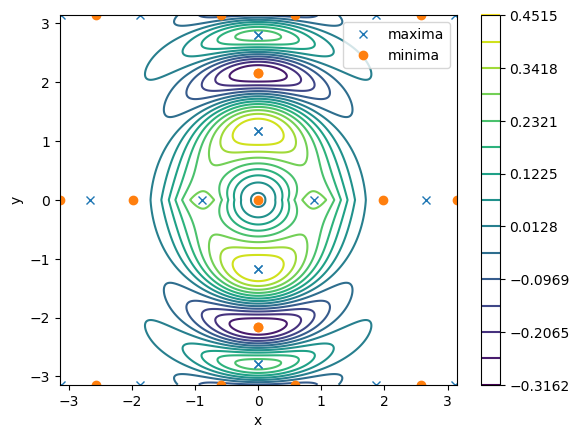

In [504]:
x = np.linspace(-np.pi, np.pi, 1000)
y = np.linspace(-np.pi, np.pi, 1000)

xx, yy = np.meshgrid(x, y)

z = (1 / (np.abs(yy) + 1)) * np.sin(xx**2 + yy**2) * np.exp(-(xx**2))
levels = np.linspace(np.min(z), np.max(z), 15)
plt.contour(xx, yy, z, levels=levels, extent=[-np.pi, np.pi, -np.pi, np.pi])
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
maxima = (z >= np.roll(z, 1, axis=0)) & (z >= np.roll(z, -1, axis=0)) & (z >= np.roll(z, 1, axis=1)) & (z >= np.roll(z, -1, axis=1))
minima = (z <= np.roll(z, 1, axis=0)) & (z <= np.roll(z, -1, axis=0)) & (z <= np.roll(z, 1, axis=1)) & (z <= np.roll(z, -1, axis=1))
plt.plot(xx[maxima], yy[maxima], 'x', label="maxima")
plt.plot(xx[minima], yy[minima], 'o', label='minima')
plt.legend()
plt.show()

### 2. Reading and working with data in a FITS file

Download the file `acisf26248N001_evt2.fits` from the course website. This is an X-ray photon event file from a 25 ksec (25,120 seconds) Chandra ACIS-I observation of the supernova remnant Cassiopeia A (Cas A). In X-rays most astronomical sources are faint enough that we receive one photon at a time.  Thus, detectors usually don't record an image with intensities in an array of pixels.  They usually produce files giving information about the arrival of each photon, including its position in the focal plane and its energy.

In this problem you will read in, analyze, and plot results from this file. The file contains an empty primary HDU and two binary table extension HDUs. Each row of the first binary table (EVENTS) corresponds to a single X-ray photon. The table columns that we care about (see the header for the full list) are X, Y, and ENERGY. (X,Y) is the pixel location of the photon in a plane tangent to the sky. See the EVENTS header for the values of X and Y axis reference pixel [TCRPX11 and TCRPX12], sky coordinate value of reference pixel [TCRVL11/12], and pixel size needed to derive sky positions from table values [TCDLT11/12]). ENERGY is the energy of the photon in electron volts (eV).

Note: we are going to skip some of the standard X-ray data analysis steps, such as limiting counts to time intervals considered to produce reliable observations and accounting for the detector response matrix. 


**a)** Write code to read the file and select the data by photon energy so that you have a
NumPy record array containing (X,Y) positions for photons with energies between 2.0
and 9.5 keV.   You will need to convert the (X,Y) positions from the file into sky coordinates (RA, Dec) in degrees in the following way.
Note that TCDLT11/12 and TCRVL11/12 are given in degrees. Since the NumPy trig functions take arguments in radians, and the inverse trig functions return results in radians, you will need to supply the appropriate conversion factors between radians and degrees.

\begin{align*}
 \xi & = \mathrm{TCDLT11 \cdot (X - TCRPX11)} \\
 \eta & = \mathrm{TCDLT12 \cdot (Y - TCRPX12)} \\
 \alpha_0 & = \mathrm{TCRVL11} \\
 \delta_0 & = \mathrm{TCRVL12} \\
\mathrm{RA} & = \alpha_0 + \tan^{-1} \biggl(\frac{\xi}{\cos \delta_0 - \eta \sin \delta_0}\biggr) \\
\mathrm{Dec} & = \sin^{-1}\biggl(\frac{\sin \delta_0 + \eta \cos \delta_0}{\sqrt{1+\xi^2+\eta^2}}\biggr)
\end{align*}


Use Astropy commands to get the necessary header information from the file; do not hard-code the values.

[10 pts]

In [505]:
hdulist = fits.open("acisf26248N001_evt2.fits")
x_ref = hdulist[1].header['TCRPX11']
y_ref = hdulist[1].header['TCRPX12']
x_ref_coord = hdulist[1].header['TCRVL11']
y_ref_coord = hdulist[1].header['TCRVL12']
x_pix_size = hdulist[1].header['TCDLT11']
y_pix_size = hdulist[1].header['TCDLT12']

In [506]:
data = table.Table(hdulist[1].data)
data = data[['x', 'y', 'energy']]
data = data[(data['energy'] >= 2000) & (data['energy'] <= 9500)]

In [507]:
rads = np.pi/180
degs = 180/np.pi
e = x_pix_size*rads * (data['x'] - x_ref)
n = y_pix_size*rads * (data['y'] - y_ref)

data['ra'] = x_ref_coord + np.arctan2(e, (np.cos(y_ref_coord * rads) - n * np.sin(y_ref_coord * rads))) * degs
data['dec'] = np.arcsin((np.sin(y_ref_coord * rads) + n * np.cos(y_ref_coord * rads)) / np.sqrt(1 + e**2 + n**2)) * degs
data

x,y,energy,ra,dec
float32,float32,float32,float32,float32
4811.3877,4734.3164,3473.9565,350.7389,58.85262
4632.411,4789.352,4602.755,350.78616,58.860188
4683.042,4609.748,2309.4846,350.7729,58.83564
4549.8853,4702.1343,4365.5337,350.808,58.84829
4520.6055,4693.7485,2694.231,350.81577,58.847157
4588.8105,4628.2705,4471.224,350.79776,58.838196
4400.3096,4768.022,2492.6804,350.8475,58.85733
4490.0435,4693.3823,3946.0737,350.82382,58.847107
4566.478,4624.5293,5225.1846,350.80368,58.837673


**b)** Write code to construct an image array from this selection; that is, produce a 2D mesh
covering the region of sky from which photons were received, and set the array values
equal to the number of photons that fell within each mesh cell.  Use $128^2$ mesh cells.  You can use `np.histogram2d` or you can do the gridding yourself by hand.

If you do the gridding by hand, loop over all the photons and increment the cell count of the pixel where each photon landed.  Note two things: (a) You should index your mesh using the $y-$index first; that is, if a photon's X-coordinate places it in the $ith$ mesh column and the Y-coordinate places it in the $jth$ mesh row, you should allocate it to the [j,i] index of your 2D count array. (b) RA increases eastward (leftward when looking out at the celestial sphere), while column numbers will increase toward the right when we plot the array.

Divide the photon counts by the area of each cell in square arcseconds, the effective
area of the detector (assume it to be $600 {\rm\ cm}^2$; in reality it varies with photon energy
and position), and the “live time” of the observation.  (Use the LIVETIME keyword in the
EVENTS header to get this information.)  At the end of this operation you will have an image array containing values in units of photons $arcsec^{-2}$ $cm^{-2}$ $sec^{-1}$.

[7 pts]

In [508]:
livetime = hdulist[1].header['LIVETIME']
livetime

24778.918026537

In [509]:
cell_area = 600 / 128**2

In [510]:
grid, bins1, bins2 = np.histogram2d(data['ra'], data['dec'], bins=128)
grid

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [511]:
grid = grid / cell_area / livetime
grid

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

**c)** Use the image array to produce a color image plot. The plot should have appropriate
axis ranges (remember units!) and labels and a title, and a color bar legend should be
included. Use whatever color palette you like.
By default `imshow` assumes the [0,0] element of the array is at the top left; use the `origin="lower"` argument to override this behavior.  Also, since Cas A is at a high Declination, to get the image to look square you will need to specify `aspect=R`, where R is (width in RA)/(width in Dec).  This scaling accounts for the fact that longitude lines get closer together towards the pole.

You might want to “stretch” the image to make faint features more visible by plotting,
e.g., the logarithm of the counts. If you do so, be sure to use the “unstretched” data in
the following steps.

The pdf version of this assignment has an example of what your figure should look like, if you want to check yourself.

[8 pts]

(array([58.7  , 58.725, 58.75 , 58.775, 58.8  , 58.825, 58.85 , 58.875,
        58.9  , 58.925]),
 [Text(58.7, 0, '58.700'),
  Text(58.725, 0, '58.725'),
  Text(58.75, 0, '58.750'),
  Text(58.775000000000006, 0, '58.775'),
  Text(58.800000000000004, 0, '58.800'),
  Text(58.825, 0, '58.825'),
  Text(58.85, 0, '58.850'),
  Text(58.875, 0, '58.875'),
  Text(58.900000000000006, 0, '58.900'),
  Text(58.925000000000004, 0, '58.925')])

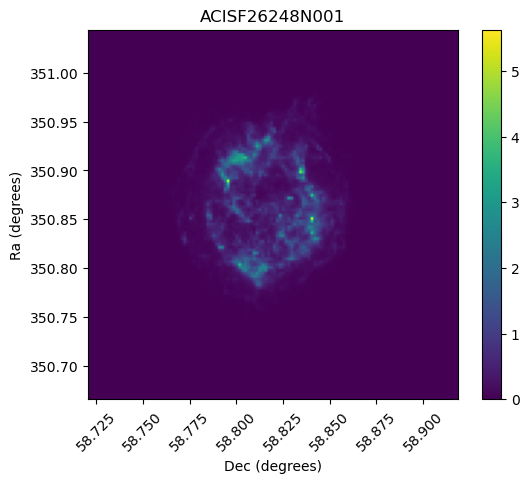

In [512]:
extent = [bins2[0], bins2[-1], bins1[0], bins1[-1]]
R = (bins2[-1] - bins2[0]) / (bins1[-1] - bins1[0])
plt.imshow(grid, origin='lower', extent=extent, aspect=R)
plt.colorbar()
plt.xlabel("Dec (degrees)")
plt.ylabel("Ra (degrees)")
plt.title("ACISF26248N001")
plt.xticks(rotation=45)

**d)** Designate two special regions “A” and “B” on the map. The “A” region should be a
circle of radius 2' centered on J2000 coordinates 23h23m24s, +58d48m54s. (Convert
these to decimal degrees to compare to photon positions.) The “B” region should be an
annulus centered on the same point with an inner radius of 2' and an outer radius of 3'.
Have your code draw the outline of each region on the image and label the outlines
appropriately (“A”, “B”). Because of the aspect ratio mentioned in (c), to make your
circles look circular you will need to plot them as ellipses. For example, for region “A”
you would use an ellipse of width 2 x 2'/$\cos \delta_0$ and height 2 x 2'.

[5 pts]

Text(58.85666666666666, 350.85, 'B')

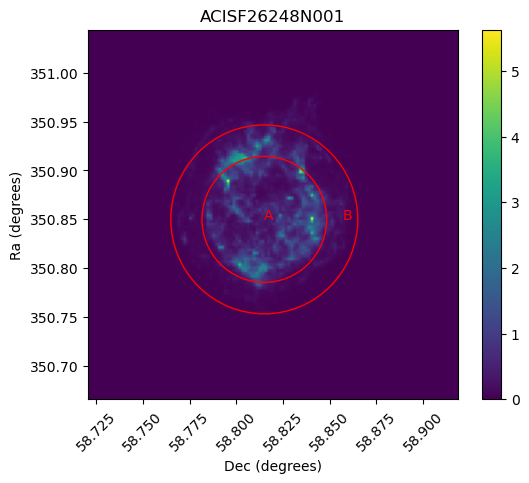

In [513]:
ra = (23 + (23/60) + (24/3600))*15
dec = 58 + (48/60) + (54/3600)

plt.imshow(grid, origin='lower', extent=extent, aspect=R)
plt.colorbar()
plt.xlabel("Dec (degrees)")
plt.ylabel("Ra (degrees)")
plt.title("ACISF26248N001")
plt.xticks(rotation=45)
ax = plt.gca()
ax.add_patch(Ellipse((dec, ra), height=2*2/60/np.cos(dec*rads), width=2*2/60, facecolor='none', edgecolor='red'))
ax.add_patch(Ellipse((dec, ra), height=2*3/60/np.cos(dec*rads), width=2*3/60, facecolor='none', edgecolor='red'))
ax.text(dec, ra, "A", color ='red')
ax.text(dec + 2.5/60, ra, "B", color='red')


### Extra credit

**e)** Return to the original file data and select photons by position so that you have two
NumPy record arrays, one containing photon energies for photons arriving in region “A”
and the other containing energies for photons in region “B.”  Apart from using the positions to select photons from the two regions we will now be interested only in their energies. Hint: you can use the coordinates of each photon to create a SkyCoord object and compute its distance to the center -- see Reading 14 again.

You might think that, since we have a position and energy for each photon, we could make a spectrum for each image pixel. However, remember that we are dealing with a limited number of photons. The number of photons needed to get a statistically reliable estimate of the radiation intensity is considerably smaller than the number needed to get a temperature or a spectrum. So usually we have to accumulate photons from a larger region of sky to construct a spectrum. That's why we're considering the two regions "A" and "B".

Write code to create a second plot showing spectra for the two regions (two curves on
one plot). The spectra should be shown as “step”-type histograms of photon counts per
cm$^2$ per second per keV versus photon energy in keV. Both x and y axes should be
logarithmic, with ranges chosen to allow the curves to fill most of the plot. Include a
legend, appropriate axis labels (remember units!), and an appropriate title. In choosing
the bin size for each curve (they do not have to be the same), ensure that at least 10
photons contribute to each bin. You will need to experiment with the bin size to find the
appropriate value.

When constructing photon energy histograms, keep in mind that the NumPy or Matplotlib histogram routines will return data that are effectively in units of photons per bin. So to get the spectra in the desired units you need to divide the histograms by effective area in cm$^2$, live time in seconds, and bin width in keV.

[20 pts]